In [1]:
!pip install wordcloud

import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/GonzaloA/fake_news/" + splits["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

# Load each split into a separate DataFrame
train_df = pd.read_parquet("hf://datasets/GonzaloA/fake_news/" + splits["train"])
validation_df = pd.read_parquet("hf://datasets/GonzaloA/fake_news/" + splits["validation"])
test_df = pd.read_parquet("hf://datasets/GonzaloA/fake_news/" + splits["test"])

# Now you have three DataFrames: train_df, validation_df, and test_df
# You can access and process them individually
print("Train Data:")
print(len(train_df))
print("\nValidation Data:")
print(len(validation_df))
print("\nTest Data:")
print(len(test_df))

Train Data:
24353

Validation Data:
8117

Test Data:
8117


In [4]:
# Combining the titles and texts into one corpus
#df['corpus'] = df["title"] + " " + df["text"]

In [5]:
train_df['corpus'] = train_df["title"] + " " + train_df["text"]
validation_df['corpus'] = validation_df["title"] + " " + validation_df["text"]
test_df['corpus'] = test_df["title"] + " " + test_df["text"]

In [6]:
# Applying data cleaning
def clean_text(text):
  text = re.sub(r'[^\w\s]', '', text) # Remove special characters
  text = text.lower() # Lowercase the text
  return text

train_df['corpus'] = train_df['corpus'].apply(clean_text)
validation_df['corpus'] = validation_df['corpus'].apply(clean_text)
test_df['corpus'] = test_df['corpus'].apply(clean_text)

In [7]:
def tokenize(text):
  """Tokenizes a given text string into a list of words."""
  return text.split()

train_df["tokens"] = train_df["corpus"].apply(tokenize)
validation_df["tokens"] = validation_df["corpus"].apply(tokenize)
test_df["tokens"] = test_df["corpus"].apply(tokenize)

In [8]:
# Split the data into training and temporary sets (test + validation)
#train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
#valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Now you have three dataframes: train_df, valid_df, and test_df
#print(f"Training set size: {len(train_df)}")
#print(f"Validation set size: {len(valid_df)}")
#print(f"Test set size: {len(test_df)}")


In [9]:
vocab_size = 2000
max_length = 120

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>") #Example
tokenizer.fit_on_texts(train_df['tokens'])

#Convert to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['tokens'])
valid_sequences = tokenizer.texts_to_sequences(validation_df['tokens'])
test_sequences = tokenizer.texts_to_sequences(test_df['tokens'])

y_train = train_df['label'].values
y_val = validation_df['label'].values
y_test = test_df['label'].values

# Pad the sequences
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_val = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences, maxlen=max_length, padding='post', truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


X_train[0]

array([   1,  245,  220,  590, 1893,    1,   65,    1,    9,    1,    8,
       1328,   92,  825,  342,  187,    1,   11, 1401,   54,    4,    2,
          1,  726,    9, 1091,  381,   16,   12,  175,    7,  594,   17,
          2,    1,    4,    2,    1,    1,    8,   11,    1,    1,    6,
          2,  294,    8,  134,  726,   29,  192,    9,    2,  501,   17,
          2,    1,   33,  501,  268,   11,    5,    1,    1,    3,   61,
        232,  530,    3,   23,    1,  311,    1,  268,    1,    2,  594,
         17,    5,  590,  351, 1364,   54,    4,   41,    1,   12,    1,
         17,    5,    1,    1,    1,    9,  190,    1,   18,    5,  620,
        456,    9,   70,  389,   54,    4,   41,    1, 1364,    2,    1,
          4,   58,  910,  311,    9,    2, 1185,    2,  245,  885],
      dtype=int32)

In [10]:
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, name="embedding"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv1d"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2, name="dropout"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
762/762 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8778 - loss: 0.2945 - val_accuracy: 0.9795 - val_loss: 0.0658
Epoch 2/5
762/762 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9828 - loss: 0.0522 - val_accuracy: 0.9810 - val_loss: 0.0594
Epoch 3/5
762/762 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9891 - loss: 0.0334 - val_accuracy: 0.9818 - val_loss: 0.0568
Epoch 4/5
762/762 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9913 - loss: 0.0291 - val_accuracy: 0.9818 - val_loss: 0.0619
Epoch 5/5
762/762 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9909 - loss: 0.0270 - val_accuracy: 0.9825 - val_loss: 0.0658


In [12]:
model.evaluate(X_test, y_test)

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9803 - loss: 0.0700


[0.0715518444776535, 0.9805346727371216]

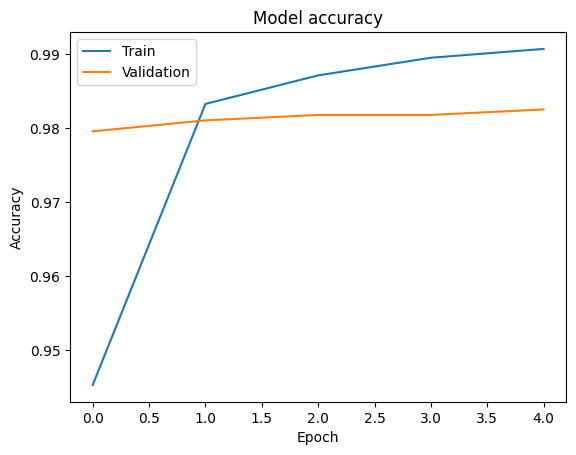

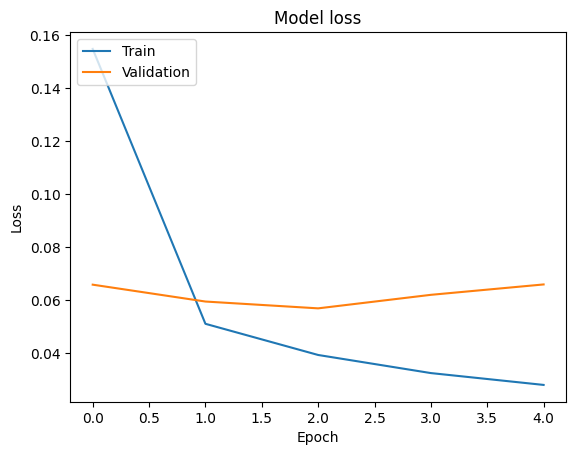

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
def predict_label(text):
  cleaned_text = clean_text(text)
  tokens = tokenize(cleaned_text)
  sequence = tokenizer.texts_to_sequences([tokens])
  padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
  prediction = model.predict(padded_sequence)[0][0]
  if prediction > 0.5:
    return "real"
  else:
    return "fake"

In [15]:
input_text = input("Enter text to classify: ")
predicted_label = predict_label(input_text)
print(predicted_label)

Enter text to classify: Tensions escalate as trump forces putins's hand into a nuclear fallout. The russian federation issued a report stating the need for equal nuclear powers between states. They began manufacturing new nuclear warheads. President Donald trump believes this is a hoax and calls his hand
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
fake


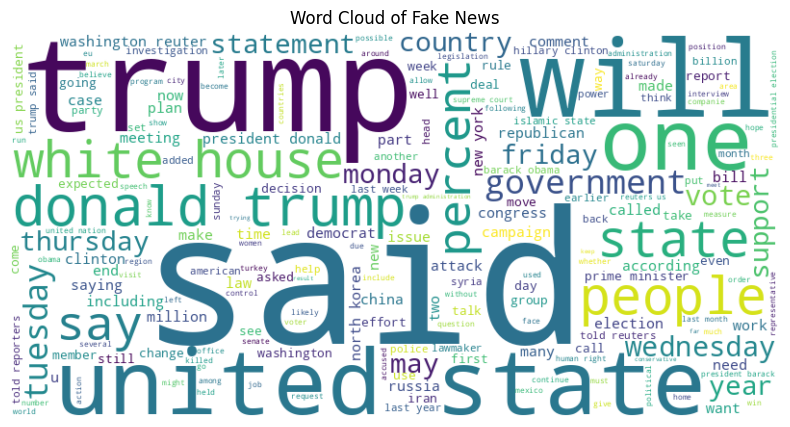

In [16]:
fake_news_text = " ".join(train_df[train_df["label"] == 1]['corpus'])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_news_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Fake News")
plt.show()

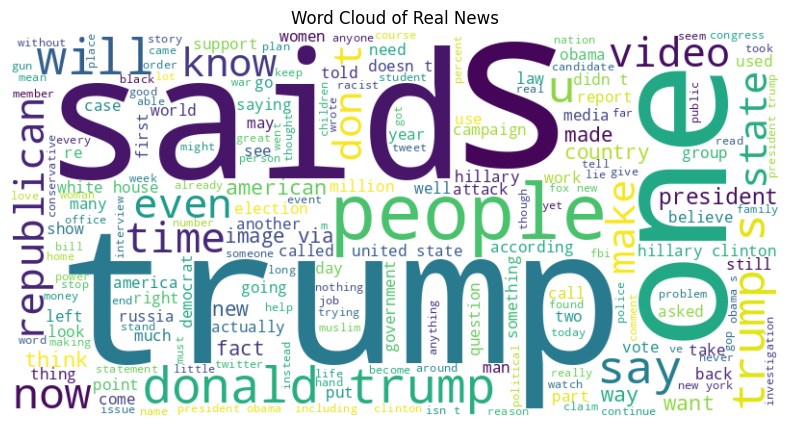

In [17]:
real_news_text = " ".join(train_df[train_df["label"] == 0]['corpus'])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(real_news_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Real News")
plt.show()